# 1. Dataset
The dataset we will be using is [IMDB movies review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which contains 50,000 reviews on movies with the labels: positive, negative

In [ ]:
import os
import pandas as pd

## 1.1 Kaggle
We will use kaggle to download the dataset.

NOTE: You will need a kaggle.json file, if you do not have it go to your Kaggle profile > account > apis and click "expire api token" and then "create new api token" this should download the kaggle.json file

In [ ]:
from google.colab.files import upload

In [ ]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

Installing kaggle
Upload kaggle.json


Saving kaggle.json to kaggle.json
Setting kaggle up...
Done!


## 1.2 Downloading dataset


In [ ]:
DATA_FILENAME = "data.csv"

In [ ]:
if not os.path.exists(DATA_FILENAME):
  !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
  print("\nUnzipping dataset...")
  !unzip -q imdb-dataset-of-50k-movie-reviews.zip
  os.rename("IMDB Dataset.csv", DATA_FILENAME)
  os.remove("imdb-dataset-of-50k-movie-reviews.zip")
  print("Dataset is ready to be cleaned!")

100% 25.7M/25.7M [00:01<00:00, 35.2MB/s]
100% 25.7M/25.7M [00:01<00:00, 22.0MB/s]

Unzipping dataset...
Dataset is ready to be cleaned!


## 1.3 Get inputs and labels
We will use pandas to read the csv file and store the two columns in thier seperate variables

In [ ]:
df = pd.read_csv(DATA_FILENAME)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X = df["review"].values
y = df["sentiment"].values

## 1.4 Splitting into train and test data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
print(
f"""
Shape of X_train, y_train: {X_train.shape}, {y_train.shape}
Shape of X_test, y_test: {X_test.shape}, {y_test.shape}
"""
)


Shape of X_train, y_train: (37500,), (37500,)
Shape of X_test, y_test: (12500,), (12500,)



## 1.5 Remove punctuation

In [ ]:
from string import punctuation

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
X_train[3]

'You know all those letters to "Father Christmas" and "Jesus" that are sent every year? Well, it turns out that they are not actually delivered but dropped off in a half-forgotten corner of the post office to rot unless some bright spark figures out a way of posting them. As bizarre settings go, it\'s a winner and one which perfectly fits the strange movie that is "Dead Letter Office". Having said that, this is obviously an Australian film as opposed to a British one. If it was Royal Mail, most letters get this sort of treatment anyway. I haven\'t been in this flat for two years and we\'re still getting letters for a Mr Wang, some female priest of the Church of Latter Day I\'ve-Never-Heard-Of-You and various catalogues for industrial equipment addressed to a plumbing company.<br /><br />"Dead Letter Office" (the name given to the place where undeliverable mail ends up) follows the story of Alice (Miranda Otto) who grows up in a seriously divided home. Writing to her absent father, she 

In [ ]:
for i, review in enumerate(X_train):
  X_train[i] = "".join([c for c in review if c not in punctuation])

In [ ]:
X_train[3]

'You know all those letters to Father Christmas and Jesus that are sent every year Well it turns out that they are not actually delivered but dropped off in a halfforgotten corner of the post office to rot unless some bright spark figures out a way of posting them As bizarre settings go its a winner and one which perfectly fits the strange movie that is Dead Letter Office Having said that this is obviously an Australian film as opposed to a British one If it was Royal Mail most letters get this sort of treatment anyway I havent been in this flat for two years and were still getting letters for a Mr Wang some female priest of the Church of Latter Day IveNeverHeardOfYou and various catalogues for industrial equipment addressed to a plumbing companybr br Dead Letter Office the name given to the place where undeliverable mail ends up follows the story of Alice Miranda Otto who grows up in a seriously divided home Writing to her absent father she only learns in adulthood that her letters ha

## 1.6 Tokenize
Here is how we will tokenize:

* Remove stopwords i.e. is, are, am
* Get 1000 most common words in our reviews
* Assign all those 1000 words a numerical value based on popularity
* Create a new list in which the items are the reviews from X_train but the review is made from the 1000 most common words.

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class Tokenizer():
  def _preprocess_word(self, word):
    # Remove any characters which are not letters
    word = re.sub(r'[^a-zA-Z]+', '', word)
    return word
  
  def _remove_stopwords(self, array):
    word_list = []

    stop_words = set(stopwords.words("english"))
    print("Getting and preprocessing words...")
    for string in tqdm(array):
      for word in string.lower().split():
        word = self._preprocess_word(word)
        if word not in stop_words and word != "":
          word_list.append(word)
    
    return word_list
  
  def tokenize(self, X_train, X_test, y_train, y_test, amount_common_words=1000):
    word_list = self._remove_stopwords(X_train)
    corpus = Counter(word_list) # Get common words
    corpus = sorted(corpus, key=corpus.get, reverse=True)[:amount_common_words] # Sort them based on commonnesss and get x (1000) amount of them
    corpus_num_dict = {w: i+1 for i, w in enumerate(corpus)} # Give numerical value to those common words

    X_train_tok, X_test_tok = [], []

    print(f"\nSetting words in arrays...")
    for review in tqdm(X_train):
      # appends the numerical value of every word in review only if it is in the 1000 most common words (corpus_num_dict)
      X_train_tok.append([corpus_num_dict[self._preprocess_word(word)] for word in review.lower().split() 
                                if self._preprocess_word(word) in corpus_num_dict.keys()])

    for review in tqdm(X_test):
      X_test_tok.append([corpus_num_dict[self._preprocess_word(word)] for word in review.lower().split() 
                                if self._preprocess_word(word) in corpus_num_dict.keys()])
    
    y_train_encodded = [1 if label == "positive" else 0 for label in y_train]
    y_test_encodded = [1 if label == "positive" else 0 for label in y_test]

    print("Tokenized!")

    return np.array(X_train_tok), np.array(y_train_encodded), np.array(X_test_tok), np.array(y_test_encodded), corpus_num_dict

In [ ]:
tokenizer = Tokenizer()

In [ ]:
X_train, y_train, X_test, y_test, vocab = tokenizer.tokenize(X_train, X_test, y_train, y_test)

Getting and preprocessing words...


  0%|          | 0/37500 [00:00<?, ?it/s]


Setting words in arrays...


  0%|          | 0/37500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Tokenized!


<ipython-input-18-1494b0777e6b>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_train_tok), np.array(y_train_encodded), np.array(X_test_tok), np.array(y_test_encodded), corpus_num_dict


In [ ]:
len(vocab)

1000

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500,), (12500,), (37500,), (12500,))

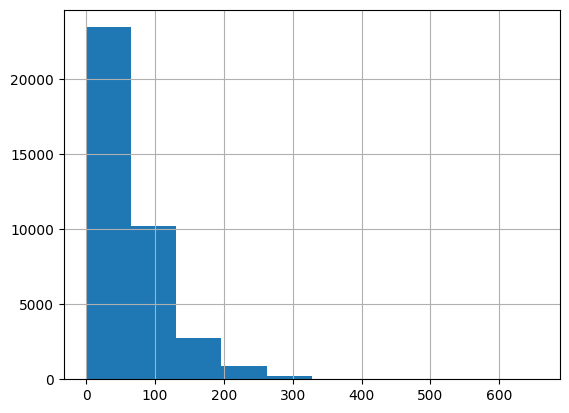

count    37500.000000
mean        69.294773
std         48.282933
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        655.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
print("")
pd.Series(rev_len).describe()

## 1.7 Load dataset

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size = 50

In [ ]:
def padding(reviews, length):
    features = np.zeros((len(reviews), length),dtype=int)
    for ii, review in enumerate(reviews):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:length]
    return features

In [ ]:
X_train_pad = padding(X_train, 500)
X_test_pad = padding(X_test, 500)

In [ ]:
train_ds = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

len(train_ds), len(train_dl)

(37500, 750)

In [ ]:
dataiter = iter(train_dl)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.shape) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 259, 425, 101],
        [  0,   0,   0,  ...,  22, 668, 668],
        [  0,   0,   0,  ..., 905,   3, 524],
        ...,
        [  0,   0,   0,  ...,   8,  52,   5],
        [  0,   0,   0,  ...,  15,   4, 115],
        [  0,   0,   0,  ...,  45, 300, 500]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0])


# 2. SentimentLSTM
Here is the structure of our neural network

* Embedding Layer
* LSTM
* Dropout Layer (0.5 dropout probability)
* Fully Connected Layer (Sigmoid Activation)

In [41]:
from torch import nn

In [42]:
class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, no_layers, output_size):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.no_layers = no_layers

    self.emb = nn.Embedding(vocab_size, embedding_dim)

    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=no_layers, batch_first=True)

    self.dropout = nn.Dropout(0.3)

    self.fc = nn.Linear(self.hidden_dim, output_size)
    self.sig = nn.Sigmoid()
  
  def initialize_hidden_state(self, batch_size):
    hidden_state = torch.zeros([self.no_layers, batch_size, self.hidden_dim]).to(device)
    cell_state = torch.zeros([self.no_layers, batch_size, self.hidden_dim]).to(device)
    return hidden_state, cell_state
  
  def forward(self, input, hidden_state):
    batch_size = input.size(0)
    embeds = self.emb(input) # Shape: B x SL x F
    lstm_out, hidden = self.lstm(embeds, hidden_state)

    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # Reshape into 2D tensor to make it suitable for the fc layer

    out = self.dropout(lstm_out)
    out = self.fc(out)

    sig_out = self.sig(out)

    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1] # Get predicted labels for each time step
    return sig_out, hidden

In [43]:
vocab_size = len(vocab) + 1
embedding_dim = 64
hidden_dim = 256
no_layers = 2
output_size = 1

In [44]:
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, no_layers, output_size).to(device)
print(model)

SentimentLSTM(
  (emb): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# 3. Loading a pretrained model
Since we have trained our model before and downloaded the h5 file we can import it and simply use that one.

NOTE: The model should be inside of a folder with the name of whatever you want.

Variables to set:
* model_zip_name: The name of zip file (should include the extension)
* model_folder_name: The name of the folder where the model file is contained
* model_filename: The name of the model file (should include the extension)

In [35]:
import zipfile

In [ ]:
model_zip_name = "sentiment_analysis_model.zip"
model_folder_name = "model"
model_filename = "model.h5"

In [36]:
print("Extracting...")
with zipfile.ZipFile(model_zip_name, "r") as zip_ref:
  zip_ref.extractall("./")
print("Done!")

Extracting...
Done!


In [45]:
print("Loading model...")
model_state_dict = torch.load(os.path.join(model_folder_name, model_filename))
model.load_state_dict(model_state_dict)
print(f"\n{model}")

Loading model...

SentimentLSTM(
  (emb): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# 4. Training
Here are the hyperparameters:
* learning rate: 0.001
* optimizer: Adam
* Criterion: Binary Cross Entropy
* Epochs: 5
* Gadient Clipping Value: 5

In [ ]:
from google.colab.files import download

In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
epochs = 5
clip_value = 5

In [ ]:
def get_acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
valid_min_loss = np.Inf
train_epoch_accs, valid_epoch_accs, train_epoch_losses, valid_epoch_losses = [], [], [], []
NA = "NA"

for epoch in range(epochs):
  print(f"Epoch: {epoch}")

  train_accuracy = 0.0
  train_losses = []
  
  valid_accuracy = 0.0
  valid_losses = []

  model.train()
  hidden_state = model.initialize_hidden_state(batch_size)

  print("Going through Training and Validation Datasets")
  for inputs, labels in tqdm(train_dl):
    inputs, labels = inputs.to(device), labels.to(device)
    hidden_state = tuple([state.data for state in hidden_state])

    optimizer.zero_grad()
    outputs, hidden_state = model(inputs, hidden_state)
    loss = criterion(outputs.squeeze(), labels.float())
    train_losses.append(loss.item())
    loss.backward()
    batch_acc = get_acc(outputs, labels)
    train_accuracy += batch_acc

    # Stop the exploding gradient problem in LSTMs
    nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
  
  model.eval()
  val_hidden_state = model.initialize_hidden_state(batch_size)
  for inputs, labels in tqdm(test_dl):
    inputs, labels = inputs.to(device), labels.to(device)
    val_hidden_state = tuple([state.data for state in hidden_state])

    outputs, val_hidden_state = model(inputs, val_hidden_state)
    loss = criterion(outputs.squeeze(), labels.float())
    valid_losses.append(loss.item())
    batch_acc = get_acc(outputs, labels)
    valid_accuracy += batch_acc

  train_loss = np.mean(train_losses)
  valid_loss = np.mean(valid_losses)
  train_acc = (train_accuracy / len(train_dl.dataset)) * 100
  valid_acc = (valid_accuracy / len(test_dl.dataset)) * 100

  train_epoch_losses.append(train_loss)
  valid_epoch_losses.append(valid_loss)

  train_epoch_accs.append(train_acc)
  valid_epoch_accs.append(valid_acc)

  print("")

  if valid_loss <= valid_min_loss:
    print(f"Validation loss decreased from {NA if valid_min_loss == np.Inf else valid_min_loss} to {valid_loss} ({valid_min_loss - valid_loss} decreased)")
    valid_min_loss = valid_loss
  else:
    print("Validation loss did not decrease")

  print(f"train_loss: {train_loss}, train_acc: {train_acc}")
  print(f"valid_loss: {valid_loss}, valid_acc: {valid_acc}")
  print(30*"=")

Epoch: 0
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from NA to 0.4730487262010574 (inf decreased)
train_loss: 0.5250854787031809, train_acc: 74.12266666666667
valid_loss: 0.4730487262010574, valid_acc: 77.968
Epoch: 1
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.4730487262010574 to 0.4064160332083702 (0.0666326929926872 decreased)
train_loss: 0.5452033914724985, train_acc: 69.416
valid_loss: 0.4064160332083702, valid_acc: 81.824
Epoch: 2
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.4064160332083702 to 0.35593443751335146 (0.050481595695018755 decreased)
train_loss: 0.4080655903617541, train_acc: 82.34133333333334
valid_loss: 0.35593443751335146, valid_acc: 84.368
Epoch: 3
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.35593443751335146 to 0.34617546743154526 (0.009758970081806206 decreased)
train_loss: 0.3367874853213628, train_acc: 85.70400000000001
valid_loss: 0.34617546743154526, valid_acc: 84.824
Epoch: 4
Going through Training and Validation Datasets


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


Validation loss decreased from 0.34617546743154526 to 0.33440550130605695 (0.011769966125488307 decreased)
train_loss: 0.3139531066715717, train_acc: 86.88533333333334
valid_loss: 0.33440550130605695, valid_acc: 85.2


In [ ]:
if not os.path.isdir("model"):
  os.mkdir("model")

In [ ]:
torch.save(model.state_dict(), "model/model.h5")

In [ ]:
!zip -r sentiment_analysis_model.zip model
download("sentiment_analysis_model.zip")

  adding: model/ (stored 0%)
  adding: model/model.h5 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Analysis

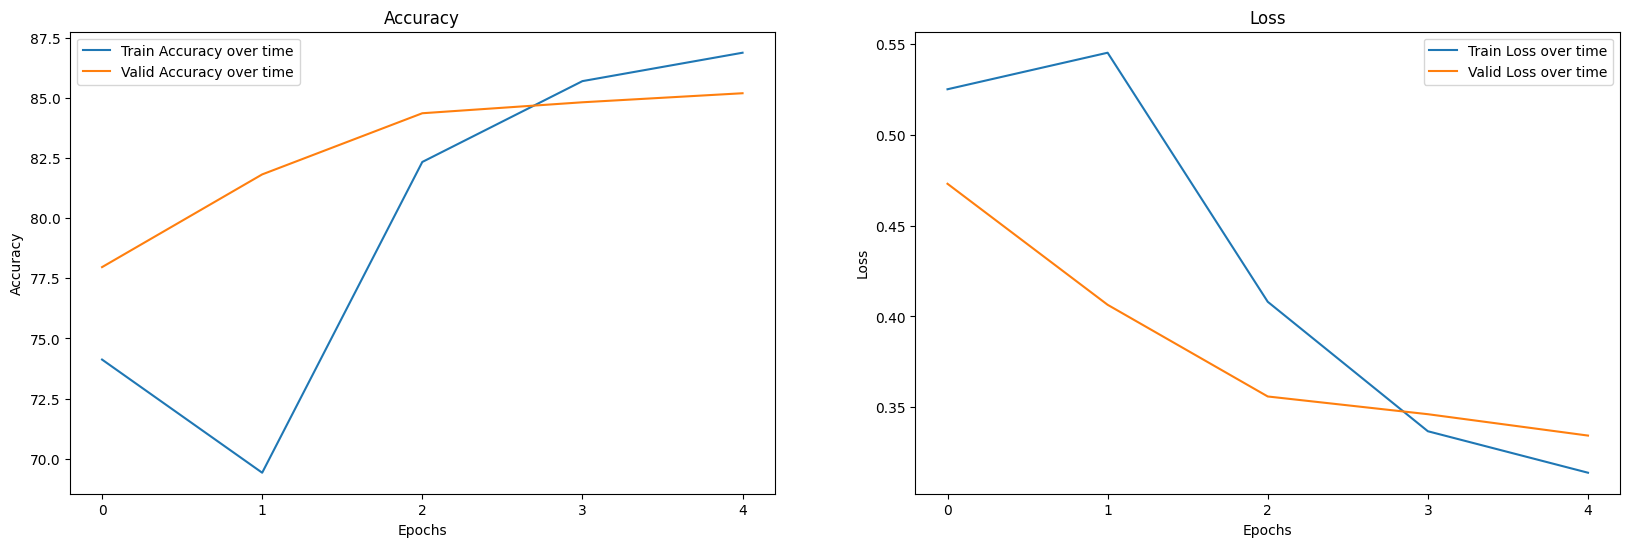

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(train_epoch_accs, label="Train Accuracy over time")
plt.plot(valid_epoch_accs, label="Valid Accuracy over time")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks([0,1,2,3,4])
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Loss")
plt.plot(train_epoch_losses, label="Train Loss over time")
plt.plot(valid_epoch_losses, label="Valid Loss over time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks([0,1,2,3,4])
plt.legend()


plt.show()

Here we can see that the validation accuracy and loss have not started flatten which indicates that we can achieve better performance with more training. We will leave it as is for now.